## Parsing and Structuring Time-Series from NASDAQ

Here the goal is to combine and tidy the individual time-series obtained from NASDAQ along with relevant metadata for further analysis.

In [2]:
import pandas as pd
import numpy as np
import json
import os 
from tqdm import tqdm

with open("config.json","r") as f:
    config = json.load(f)
    
# Read list of files    
list_of_data = os.listdir(config["data_dir"])
list_of_df = [pd.read_csv(config["data_dir"] + "/" + x)\
                                        for x in list_of_data]

for i in tqdm(range(len(list_of_data))): 
    list_of_df[i]["Symbol"] = list_of_data[i][:-4] # Add ticker symbols
    list_of_df[i]['Date'] = pd.to_datetime(list_of_df[i]['Date'], # Format date column
                                          infer_datetime_format=True)
    try:
        list_of_df[i]['Close/Last'] = pd.to_numeric(list_of_df[i]['Close/Last'].str.replace("\\$",""))
        list_of_df[i]['Open'] = pd.to_numeric(list_of_df[i]['Open'].str.replace("\\$",""))
        list_of_df[i]['High'] = pd.to_numeric(list_of_df[i]['High'].str.replace("\\$",""))
        list_of_df[i]['Low'] = pd.to_numeric(list_of_df[i]['Low'].str.replace("\\$",""))
    except:
        pass
    
ts_data = pd.concat(list_of_df)# Rbind
# Add meta data
ts_data = pd.merge(ts_data,
                   pd.read_csv(config['metadata'])[['Symbol',
                                                    'Name',
                                                    'Market Cap',
                                                    'Country',
                                                    'IPO Year',
                                                    'Sector',
                                                    'Industry'
                                                   ]]
                   ,on = "Symbol")

100%|█████████████████████████████████████████████████████████████████████████████| 3833/3833 [00:25<00:00, 144.16it/s]


In [3]:
ts_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2870346 entries, 0 to 2870345
Data columns (total 13 columns):
Date          datetime64[ns]
Close/Last    float64
Volume        float64
Open          float64
High          float64
Low           float64
Symbol        object
Name          object
Market Cap    float64
Country       object
IPO Year      float64
Sector        object
Industry      object
dtypes: datetime64[ns](1), float64(7), object(5)
memory usage: 306.6+ MB


In [4]:
# Unique sectors in the data
print (ts_data['Sector'].unique())
# Unique industries
print(ts_data['Industry'].unique())

[nan 'Health Care' 'Transportation' 'Finance' 'Technology' 'Capital Goods'
 'Consumer Durables' 'Miscellaneous' 'Basic Industries'
 'Consumer Services' 'Public Utilities' 'Energy' 'Consumer Non-Durables']
[nan 'Biotechnology: Pharmaceutical Preparations'
 'Air Freight/Delivery Services' 'Life Insurance' 'Semiconductors'
 'Industrial Machinery/Components' 'Computer Manufacturing'
 'Transportation Services' 'Major Banks' 'Business Services'
 'Biotechnology: In Vitro & In Vivo Diagnostic Substances'
 'Medical/Dental Instruments'
 'Biotechnology: Biological Products (No Diagnostic Substances)'
 'Hospital/Nursing Management' 'EDP Services' 'Specialty Chemicals'
 'Specialty Insurers' 'Multi-Sector Companies'
 'Computer Software: Prepackaged Software' 'Industrial Specialties'
 'Telecommunications Equipment' 'Medical/Nursing Services' 'Advertising'
 'Electrical Products' 'Building operators'
 'Diversified Commercial Services' 'Electric Utilities: Central'
 'Environmental Services' 'Television 

In [20]:
# Date range
print(ts_data['Date'].max(),"-",ts_data['Date'].min())

2021-12-10 00:00:00 - 2016-12-05 00:00:00


In [5]:
from tqdm import tqdm
# add % valuation change for a given ticker
tickers = ts_data['Symbol'].unique()
def calculate_perc_change(ticker):
    x = ts_data[ts_data['Symbol'] == ticker]
    price_diff = -1 * np.diff(x['Close/Last'])
    price_diff_perc = 100 * (price_diff / x['Close/Last'][1:])
    price_diff_perc = np.append(price_diff_perc,0)
    x['price_diff_perc'] = price_diff_perc
    return x
ts_data_expand = [calculate_perc_change(ticker) for ticker in tqdm(tickers)]
ts_data_expand = pd.concat(ts_data_expand)    

  0%|                                                                                         | 0/3822 [00:00<?, ?it/s]C:\Users\OZAN\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
100%|██████████████████████████████████████████████████████████████████████████████| 3822/3822 [15:30<00:00,  4.16it/s]


In [6]:
ts_data_expand.head()

,Date,Close/Last,Volume,Open,High,Low,Symbol,Name,Market Cap,Country,IPO Year,Sector,Industry,price_diff_perc
0,2021-12-03,9.780,6389.0,9.770,9.780,9.750,AACI,Armada Acquisition Corp. I Common Stock,202538910.0,United States,2021.0,NaN,NaN,0.051151
1,2021-12-02,9.775,43524.0,9.780,9.790,9.760,AACI,Armada Acquisition Corp. I Common Stock,202538910.0,United States,2021.0,NaN,NaN,-0.051125
2,2021-12-01,9.780,101595.0,9.880,9.880,9.780,AACI,Armada Acquisition Corp. I Common Stock,202538910.0,United States,2021.0,NaN,NaN,-0.051099
3,2021-11-30,9.785,NaN,9.785,9.785,9.785,AACI,Armada Acquisition Corp. I Common Stock,202538910.0,United States,2021.0,NaN,NaN,-0.000000
4,2021-11-29,9.785,1436.0,9.890,9.890,9.780,AACI,Armada Acquisition Corp. I Common Stock,202538910.0,United States,2021.0,NaN,NaN,4.764454


In [13]:
ts_data_expand.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2870346 entries, 0 to 2870345
Data columns (total 14 columns):
Date               datetime64[ns]
Close/Last         float64
Volume             float64
Open               float64
High               float64
Low                float64
Symbol             object
Name               object
Market Cap         float64
Country            object
IPO Year           float64
Sector             object
Industry           object
price_diff_perc    float64
dtypes: datetime64[ns](1), float64(8), object(5)
memory usage: 328.5+ MB


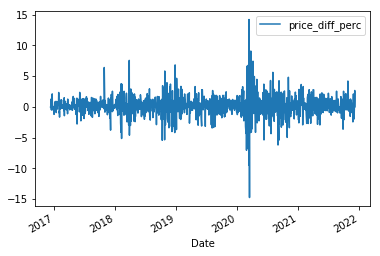

In [11]:
ts_data_expand[ts_data_expand['Symbol'] == "MSFT"].plot(x = "Date", y = "price_diff_perc")

In [12]:
# Serialize and save the data
import pickle as pkl
with open("./data/ts_data.pkl","wb") as f:
    pkl.dump(ts_data_expand,f)

In [2]:
import pickle as pkl
import numpy as np
import pandas as pd

with open("./data/ts_data.pkl", 'rb') as f:
    ts_data = pkl.load(f)

## Exploration and building expectations from data

### Which stocks had highest % yield since 2017?

In [30]:
ts_data_summary = ts_data.groupby("Symbol",as_index= False)\
    ['price_diff_perc'].sum().\
    sort_values('price_diff_perc',ascending = False)
    
ts_data_summary.head(10)    

,Symbol,price_diff_perc
2789,PNTG,1.509000e+07
2728,PFHD,1.349996e+07
3427,TOI,9.699890e+06
3609,VINC,9.349938e+06
3428,TOIIW,2.479944e+06
2241,MDIA,1.920580e+06
2700,PCTTW,1.050259e+06
557,BRY,9.499427e+05
1420,FVE,6.535715e+05
242,APPHW,5.490594e+05


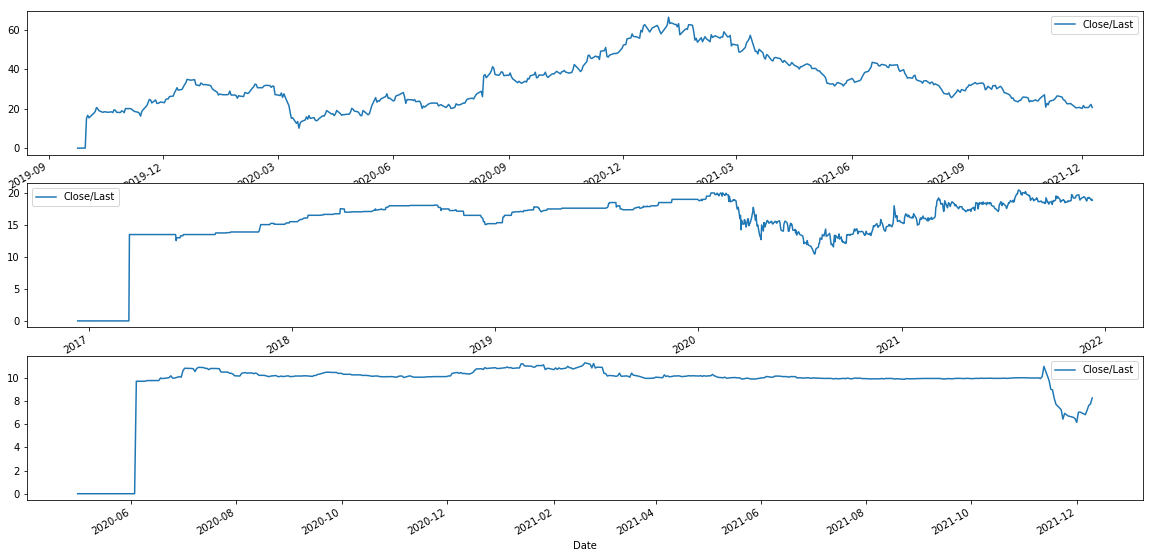

In [31]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)
fig, axes = plt.subplots(nrows=3)
ts_data[ts_data.Symbol == "PNTG"].plot.line(x = "Date", y = "Close/Last",ax= axes[0])
ts_data[ts_data.Symbol == "PFHD"].plot.line(x = "Date", y = "Close/Last",ax= axes[1])
ts_data[ts_data.Symbol == "TOI"].plot.line(x = "Date", y = "Close/Last",ax= axes[2])

In [35]:
ts_data[ts_data.Symbol == "PFHD"][['Date','Close/Last']].tail()

,Date,Close/Last
2037047,2016-12-16,0.0001
2037048,2016-12-15,0.0001
2037049,2016-12-14,0.0001
2037050,2016-12-13,0.0001
2037051,2016-12-12,0.0001


In [36]:
ts_data[ts_data.Symbol == "TOI"][['Date','Close/Last']].tail()

,Date,Close/Last
2546535,2020-05-07,0.0001
2546536,2020-05-06,0.0001
2546537,2020-05-05,0.0001
2546538,2020-05-04,0.0001
2546539,2020-05-01,0.0001


It looks like the initial market prices for recent stocks are recorded as 0.0001, which is creating an anomaly in the data. Let's clean up these records to get a more realistic picture on valuation.

In [37]:
ts_data = ts_data[ts_data['Close/Last'] != 0.0001]

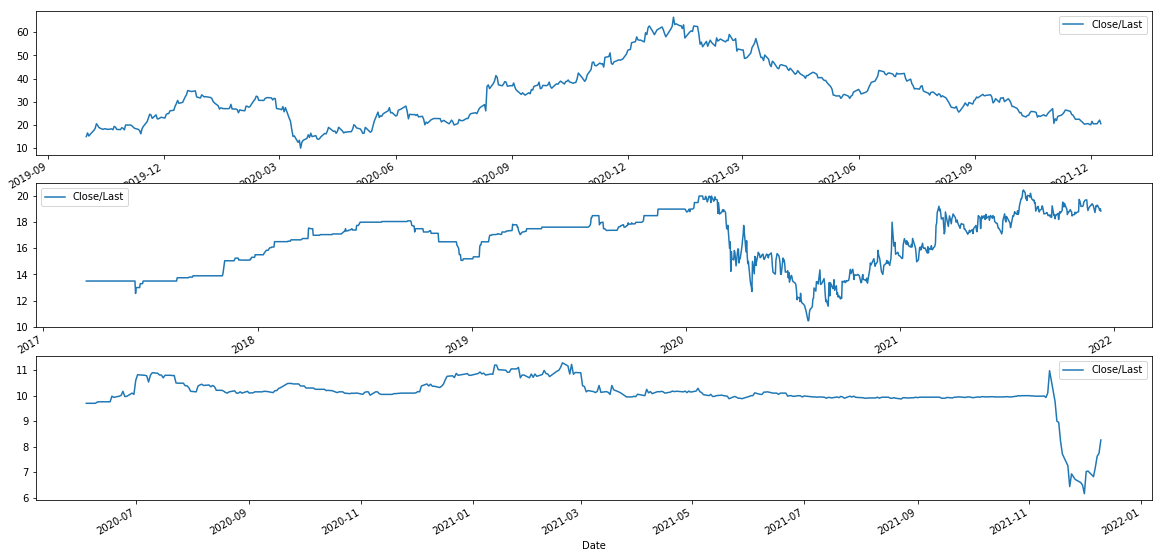

In [38]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)
fig, axes = plt.subplots(nrows=3)
ts_data[ts_data.Symbol == "PNTG"].plot.line(x = "Date", y = "Close/Last",ax= axes[0])
ts_data[ts_data.Symbol == "PFHD"].plot.line(x = "Date", y = "Close/Last",ax= axes[1])
ts_data[ts_data.Symbol == "TOI"].plot.line(x = "Date", y = "Close/Last",ax= axes[2])

In [39]:
ts_data_summary = ts_data.groupby("Symbol",as_index= False)\
    ['price_diff_perc'].sum().\
    sort_values('price_diff_perc',ascending = False)
    
ts_data_summary.head(10)    

,Symbol,price_diff_perc
2789,PNTG,1.509000e+07
2728,PFHD,1.349996e+07
3427,TOI,9.699890e+06
3609,VINC,9.349938e+06
3428,TOIIW,2.479944e+06
2241,MDIA,1.920580e+06
2700,PCTTW,1.050259e+06
557,BRY,9.499427e+05
1420,FVE,6.536715e+05
242,APPHW,5.490594e+05


In [40]:
ts_data[ts_data.Symbol == "TOI"].tail()

,Date,Close/Last,Volume,Open,High,Low,Symbol,Name,Market Cap,Country,IPO Year,Sector,Industry,price_diff_perc
2546512,2020-06-10,9.75,110300.0,9.81,9.81,9.75,TOI,The Oncology Institute Inc. Common Stock,525114515.0,United States,2020.0,Health Care,Medical Specialities,5.154639e-01
2546513,2020-06-09,9.70,NaN,9.70,9.70,9.70,TOI,The Oncology Institute Inc. Common Stock,525114515.0,United States,2020.0,Health Care,Medical Specialities,-0.000000e+00
2546514,2020-06-08,9.70,NaN,9.70,9.70,9.70,TOI,The Oncology Institute Inc. Common Stock,525114515.0,United States,2020.0,Health Care,Medical Specialities,-0.000000e+00
2546515,2020-06-05,9.70,NaN,9.70,9.70,9.70,TOI,The Oncology Institute Inc. Common Stock,525114515.0,United States,2020.0,Health Care,Medical Specialities,-0.000000e+00
2546516,2020-06-04,9.70,50000.0,9.70,9.70,9.70,TOI,The Oncology Institute Inc. Common Stock,525114515.0,United States,2020.0,Health Care,Medical Specialities,9.699900e+06


In [1]:
%qtconsole